This notebook will cover the SpikeInterface pipeline for extracellular analysis and spike sorting comparison. 

Spikeinterface wraps 5 subpackages: spikeextractors, spikesorters, spiketoolkit, spikecomparison, and spikewidgets.

For this analysis, we will use our 384-channel dataset from Neuropixels obtained during the PVT-Manual slow paradigm experimentation with vestibular stimulation by rotation of the stage.

The summary of the pipeline is the following :

- load the data with spikeextractors package
- load the probe information using ProbeInterface
- preprocess the signals
- run a popular spike sorting algorithm with different parameters
- curate the spike sorting output using 1) quality metrics (automatic) - 2) Phy (manual) - 3) consensus-based

All these operations are executed in a new Python 3.7 Anaconda environment named "Spikeline" specifically created for the data analysis purposes.


# Importing the modules

Let's now import the `spikeinterface` modules that we need.

In [1]:


import os 
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display
from IPython import get_ipython
from varname import nameof
from scipy.ndimage.filters import gaussian_filter1d
plt.rcParams.update({'font.size': 14})
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

18:42:05 [I] klustakwik KlustaKwik2 version 0.2.6


hello


## Loading recording and probe information


In [2]:
# Add the path to the folder containing the data folder where are stored 


Path_to_folder_containing_data = r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0'

Path = r'F:\Data_recording\003WO.1_014_PVT_2_103_g0_imec0'
# Function to read the file with the dedicated SpikeExtractor for the output of our recording software SpikeGLX, the function does a loop in case other recording folders exist but here we have only one analysis
def Read_file(Path_to_folder_containing_data):
    for fichier in os.listdir(Path_to_folder_containing_data):        
        if fichier.endswith('.imec0.ap.bin'):
            recording = se.SpikeGLXRecordingExtractor(file_path=os.path.join(Path_to_folder_containing_data,fichier))
            file_path = os.path.join(Path_to_folder_containing_data,fichier)
            print(file_path)
            return recording
        
recording = Read_file(Path_to_folder_containing_data)


F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\003WO.1_007_PVTmanual_slowslow_g0_t0.imec0.ap.bin


## Exploring the data before pre-processing it

Text(0.5, 1.0, 'Recording traces')

Text(0.5, 0, 'Time(s)')

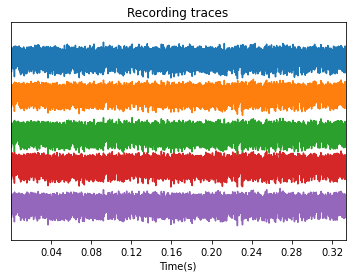

In [3]:
#SpikeWidgets is a package of the SpikeInterface project that was designed for visualization of various aspects of the spike sorting pipeline. 
#The widgets include: raster plots, autocorrelograms, crosscorrelograms, isi distributions, and more.
#We look at the data before pre-processing stage


range1 = [range(48,52)]
range2 = [*range(91,96)]
range3 = [range(59,65)]
#Visualizing the recording extractor object
w_ts = sw.plot_timeseries(recording, channel_ids=range2)
plt.title('Recording traces')
plt.xlabel('Time(s)')


In [4]:
#SpikeToolkit is a package of the SpikeInterface project is designed for efficient preprocessing, postprocessing, evaluation, and curation of extracellular datasets and spike sorting outputs.
#We can now pre-process uniformly the recording for the spikesorters


def pre_processing(recording):
    #We remove the ground channel from the recording
    recording1 = st.preprocessing.remove_bad_channels(recording, bad_channel_ids=[191])
    #Filtering to separate them: high pass filtering for the spikes (generally set at 6000Hz) and low-pass filtering for the synaptic mechanisms (generally set at 300Hz).  
    recording2 = st.preprocessing.bandpass_filter(recording1, freq_min=300, freq_max=6000)
    #Whiten the signal
    recording3 = st.preprocessing.whiten(recording2)
    #Application of common median reference, the median of the selected channels is removed for each timestamp
    recording4 = st.preprocessing.common_reference(recording3, reference='median')
    return recording4


recording_preprocessed = pre_processing(recording=recording)


In [5]:

#All operations in SpikeInterface are lazy, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to cache it to a file and perform those operations (eg. filters, CMR, etc.) at once. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general post-process the results.
#If we now closed the Python session, we would have a nice .dat file, but no information on how to open it! In order to save the state of an extractor, we can use the dumping mechanism. Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:
def dump_to_pkl(recording,Path_to_folder_containing_data):
    recording_cache = se.CacheRecordingExtractor(recording, n_jobs=1, chunk_mb=500, verbose=True)
    recording_cache.filename
    recording_cache.get_tmp_folder()
    recording_cache.move_to(Path_to_folder_containing_data+'/dataall.dat') 
    recording_cache.dump_to_dict()
    pkl = Path_to_folder_containing_data+'/filtered_dataall_'+ os.path.basename(Path_to_folder_containing_data)+'.pkl'
    recording_cache.dump_to_pickle(pkl)
    return pkl

#dump_to_pkl(recording=recording_preprocessed,Path_to_folder_containing_data=Path_to_folder_containing_data)

#Loading the filtered data stored in pkl. In another session, we can pick up from where we left by loading the extractor from the pickle file:
def load_recording(pkl_path):
    recording_loaded = se.load_extractor_from_pickle(pkl_path)
    return recording_loaded

pkl_path=Path_to_folder_containing_data+'/filtered_dataall_'+ os.path.basename(Path_to_folder_containing_data)+'.pkl'
recording_loaded = load_recording(pkl_path)

Text(0.5, 1.0, 'Recording traces')

Text(0.5, 0, 'Time(s)')

Text(0, 0.5, 'Voltage')

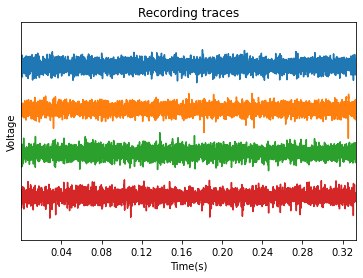

In [6]:
#Pre-processed data loaded plot view

w_ts = sw.plot_timeseries(recording_preprocessed, channel_ids=[209, 181, 26, 30])
plt.title('Recording traces')
plt.xlabel('Time(s)')
plt.ylabel('Voltage')

## Spike sorting

In [7]:

#We can now run spike sorting on the above recording. We decided to use 3 sorters in the purpose of our analysis, HerdingSpikes, Ironclust, Kilosort2 and Tridesclous
#Functions are defined for each sorter
#We can check that all the sorters we want to use are installed
ss.available_sorters()

#For MATLAB-based sorters - Ironclust and Kilosort2, we had to clone the sorter repo and point it to SpikeInterface
def Run_Kilosort(recording_loaded,Path_results):
    ss.Kilosort2Sorter.set_kilosort2_path(r'F:\Sorters\Kilosort2')
    Path_kilosort_results = os.path.join(Path_results,'_KS2_results')
    os.mkdir(Path_kilosort_results)
    sorting_KS2 = ss.run_kilosort2(recording_loaded, car = 'False', output_folder=Path_kilosort_results)
    return sorting_KS2, Path_kilosort_results

def Run_Tridesclous(recording_loaded,Path_results):
    Path_tridesclous_results = os.path.join(Path_results,'_TDC_results')
    os.mkdir(Path_tridesclous_results)
    sorting_TDC = ss.run_tridesclous(recording_loaded, detect_threshold = 6, output_folder=Path_tridesclous_results)
    return sorting_TDC, Path_tridesclous_results

def Run_Ironclust(recording_loaded,Path_results):
    ss.IronClustSorter.set_ironclust_path(r'F:\Sorters\ironclust2')
    Path_ironclust_results = os.path.join(Path_results,'_Ironclust_results')
    os.mkdir(Path_ironclust_results)
    sorting_IC = ss.run_ironclust(recording_loaded, output_folder=Path_ironclust_results, detect_threshold = 6, pc_per_chan = 3, common_ref_type = 'none')
    return sorting_IC, Path_ironclust_results


def Run_sorters(recording_loaded,Path_to_folder_containing_data):
    Path_results=os.path.join(Path_to_folder_containing_data,'Sorting_results')
    os.mkdir(Path_results)
    Sorters = []
    Pathsresults = []
    try :
        sorting_KS2, Path_kilosort_results = Run_Kilosort(recording_loaded,Path_results)
        Sorters.append(sorting_KS2)
        Pathsresults.append(Path_kilosort_results)
    finally:
           try :
                sorting_TDC, Path_tridesclous_results = Run_Tridesclous(recording_loaded=recording_loaded,Path_results=Path_results)
                Sorters.append(sorting_TDC)
                Pathsresults.append(Path_tridesclous_results)     
           finally:
                  try :
                      sorting_IC, Path_ironclust_results = Run_Ironclust(recording_loaded=recording_loaded,Path_results=Path_results)
                      Sorters.append(sorting_IC)
                      Pathsresults.append(Path_ironclust_results)
                  finally:
                      return Sorters, Pathsresults


['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'spykingcircus',
 'tridesclous',
 'waveclus',
 'yass']

In [8]:

Path_results = r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\Sorting_results'

#To perform manual curation later we will export the data to Phy.
def Export_to_Phy(sorting, result_paths, recording_loaded):
    for i in range(0,len(sorting)):
        try :
            Path_phy_result = os.path.join(result_paths[i], 'Phy')
            st.postprocessing.export_to_phy(recording_loaded, 
                                    sorting[i], output_folder=Path_phy_result,verbose=True, recompute_info=True, n_jobs=1,max_channels_per_template=10)
        finally :
            pass

Path_kilosort_results= r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\Sorting_results\_KS2_results'
Path_tridesclous_results =r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\Sorting_results\_TDC_results'
Path_ironclust_results =r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\Sorting_results\_Ironclust_results\tmp\firings.mda'

#The sorting extractors allow to reload easily the sorting results obtained
sorting_KS2 = se.KiloSortSortingExtractor(Path_kilosort_results)
sorting_TDC = se.TridesclousSortingExtractor(Path_tridesclous_results)
sorting_IC = se.MdaSortingExtractor(Path_ironclust_results)

The datatsource is not found {'filenames': ['D:\\Data_meeting_Flavia\\003WO.1_007_PVTmanual_slowslow_g0_imec0\\dataall.dat'], 'dtype': '<f4', 'sample_rate': 30000.168908, 'total_channel': 384, 'offset': 0}


In [9]:

#The spike sorting returns a SortingExtractor object. Let's see show many units Kilosort2 found
print('Units', sorting_KS2.get_unit_ids())



Units [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


## Post-processing

Text(0.5, 1.0, 'Raster plot')

Text(0.5, 0, 'Time(s)')

Text(0, 0.5, 'Unit id')

(300, 384, 180)

1820

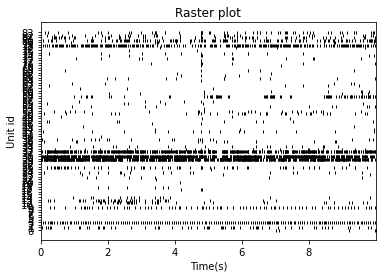

In [10]:

#The postprocessing submodule of spiketoolkit allow us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores.
#It allows to post-process the data directly through the API before exporting it to Phy
#We can visualize the raster plot of the spiking activity of a group of neurons over time. In a raster plot each row (y-axis) corresponds to the index of a neuron in a neuron group. The columns (x-axis) corresponds to the current time in the simulation. 
#The presence of a dot in a given row and column, indicates that the neuron whose index corresponds to that row produced an action potential (spike) at the time corresponding to that column. For instance, if neuron 2 spikes at time 10 a dot will appear in row 2 at the column representing the 10th time index. 
#Extending this it can be seen that a raster plot displays the pattern of spikes across a neuron group over time.

w_rs = sw.plot_rasters(sorting_KS2, trange=[0,10])
plt.title('Raster plot')
plt.xlabel('Time(s)')
plt.ylabel('Unit id')

#We can see that the unit 78 presents a lot of activity along time, we can take a further look at it by looking at the waveforms and templates extracted
#Each waveform is associated with a specific spike, so they are saved as spike features

waveforms = st.postprocessing.get_unit_waveforms(recording_loaded, sorting_KS2)
waveforms[78].shape
len(sorting_KS2.get_unit_spike_train(78))

#100 waveforms were extracted from the 1820 spike train of the first unit.



## Extra-cellular features

In [11]:


#Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes. The postprocessing module of spiketoolkit allows one to compute several of these features:
#These consist of a set of 1D features,  Metrics come from Jia et al. (2019) High-density extracellular probes reveal dendritic backpropagation and facilitate neuron classification. J Neurophys
# https://doi.org/10.1152/jn.00680.2018

#- peak to valley (peak_to_valley), time between peak and valley
#- halfwidth (halfwidth), width of peak at half its amplitude
#- peak trough ratio (peak_trough_ratio), amplitude of peak over amplitude of trough
#- repolarization slope (repolarization_slope), slope between trough and return to base
#- recovery slope (recovery_slope), slope after peak towards baseline
# After calculation an excel database containing the concatenation of the results for all the sorters is exported in the Sorters_results folder of the recording

st.postprocessing.get_template_features_list()
Sorters = [sorting_KS2,sorting_TDC,sorting_IC]
Sorters_name = ['sorting_KS2','sorting_TDC','sorting_IC']
def calculate_metrics(recording_loaded,Sorters,Path_results):
    columns_names = ['Id_key','id_cluster','peak_to_valley','halfwidth', 'peak_trough_ratio','repolarization_slope', 'recovery_slope','Sorter']
    df=pd.DataFrame(columns = columns_names)
    i=0
    for s in Sorters :
        metrics = st.postprocessing.compute_unit_template_features(recording=recording_loaded, sorting=s, as_dataframe=True)
        metrics['id_cluster']=metrics.index
        metrics = metrics.applymap(str)
        metrics = metrics.assign(Sorter=Sorters_name[i])
        metrics['Id_key'] = metrics['id_cluster']+ metrics['Sorter']
        df = df.append(metrics)
        i+=1
    df.to_excel(os.path.join(Path_results,'metrics_sorters.xlsx'), index = False)
    return df
    
df = calculate_metrics(recording_loaded,Sorters,Path_results)
display(df)

['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

C:\Users\flavi\anaconda3\envs\Spikeline\lib\site-packages\scipy\stats\_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\flavi\anaconda3\envs\Spikeline\lib\site-packages\scipy\stats\_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\flavi\anaconda3\envs\Spikeline\lib\site-packages\scipy\stats\_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


,Id_key,id_cluster,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope,Sorter
0,0sorting_KS2,0,0.0029666499636362646,0.0056333016163430194,-0.43529412150382996,1034604.0393495536,-136425.28109340102,sorting_KS2
1,1sorting_KS2,1,0.00383331175076596,0.006033299364249033,0.2704918086528778,nan,-47073.114058666804,sorting_KS2
2,2sorting_KS2,2,0.00016666572829417218,0.0051999707227781715,-1.6644736528396606,3849631.049327324,-777322.7612500505,sorting_KS2
3,3sorting_KS2,3,0.0003666646022471788,nan,6.08695650100708,nan,-34836.84386688921,sorting_KS2
4,4sorting_KS2,4,0.0009333280784473641,0.005266637014095841,-1.7006802558898926,3445331.8980281185,-3997790.365641963,sorting_KS2
...,...,...,...,...,...,...,...,...
4,4sorting_IC,4,0.00013333258263533774,0.00013333258263533774,-0.6016949415206909,nan,-190575.3424644765,sorting_IC
5,5sorting_IC,5,0.00013333258263533774,0.00013333258263533774,-0.36538460850715637,3093767.41863749,-168020.42651396102,sorting_IC
6,6sorting_IC,6,0.0003999977479060132,0.006033299364249033,0.3083333373069763,nan,-40818.00578898942,sorting_IC
7,7sorting_IC,7,0.00016666572829417218,0.00013333258263533774,-0.7423312664031982,2425794.9077953044,-176238.8169412743,sorting_IC


## Validation

In [12]:

#The spiketoolkit package also provides several functions to compute qualitity metrics about the spike sorting results through the validation module

#For Neuropixels recordings with minimal electrode drift, Kilosort2 performs well enough that further manual curation is not necessary. Unlike the original version of Kilosort, which required a manual merging step, Kilosort2 attempts to merge units automatically. Sometimes it over-merges, leading to units that clearly combine spikes from multiple cells. But in the majority of cases, Kilosort2 makes merging decisions as well as a human would, and does so in a way that is highly reproducible.

#Because there is no "ground truth" information available in these datasets, any sorting algorithm is bound to make mistakes. Quality metrics allow us to understand the types of mistakes that are occurring, and obtain an estimate of their severity. Some common errors that can be identified by quality metrics include:
#Assigning spikes from multiple neurons to the same cluster
#Missing spikes from neurons with waveform amplitude near the spike detection threshold
#Failing to track neurons with waveforms that change as a result of electrode drift
#These mistakes can occur even in units that appear to be extremely well isolated. It's misleading to conceive of units as existing in two distinct categories, one with perfectly clean "single units" and one with impure "multiunits." Instead, there's a gradient of qualities, with mostly complete, uncontaminated units at one end, and incomplete, highly contaminated units at the other.
#List of available metrics, taken from the allen institute : https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html
st.validation.get_quality_metrics_list()
#- num_spikes, Computes and returns the num spikes for the sorted dataset.
#- firing_rate, Firing rate is equal to the total number of spikes divided by the number of seconds in the recording.
#- presence_ratios, It measures the fraction of time during a session in which a unit is spiking, and ranges from 0 to 0.99 (an off-by-one error in the calculation ensures that it will never reach 1.0).
#- isi_violations, Inter-spike-interval (ISI) violations are a classic measure of unit contamination. Because all neurons have a biophysical refractory period, we can assume that any spikes occurring in rapid succession (<1.5 ms intervals) come from two different neurons. Therefore, the more a unit is contaminated by spikes from multiple neurons, the higher its isi_violations value will be.
#- amplitude cutoff, Unlike presence ratio, which detects units that drift out of the recording, amplitude cutoff provides an estimate of the false negative rate—e.g., the fraction of spikes below the spike detection threshold. Thus, amplitude cutoff is a measure of unit "completeness" that is complementary to presence ratio.
#- isolation_distances,Isolation distance calculates the size of the 96-dimensional sphere that includes as many "other" spikes as are contained in the original unit's cluster, after normalizing the clusters by their standard deviation in each dimension (Mahalanobis distance).
#- nn_metrics, This metric looks at the PCs for one unit and calculates the fraction of their nearest neighbors that fall within the same cluster. If a unit is highly contaminated, then many of the closest spikes will come from other units
#- These additional metrics are added to the previous database with the postprocessing metrics
def calculate_additional_metrics(recording_loaded,Sorters,Path_results):
    df = pd.read_excel(os.path.join(Path_results,'metrics_sorters.xlsx'))
    columns_names_to_add =  ["Id_key",'id_cluster',"num_spikes", "firing_rate", "presence_ratio", "isi_violation", "amplitude_cutoff", "snr","max_drift", "cumulative_drift", "silhouette_score", "isolation_distance", "l_ratio","d_prime", "nn_hit_rate", "nn_miss_rate"]
    df2=pd.DataFrame(columns = columns_names_to_add)
    i=0
    Metrics_per_sorter = list()
    for s in Sorters :
        metrics2 = st.validation.compute_quality_metrics(sorting=s, recording=recording_loaded, metric_names=["num_spikes", "firing_rate", "presence_ratio", "isi_violation", "amplitude_cutoff", "snr","max_drift", "cumulative_drift", "silhouette_score", "isolation_distance", "l_ratio","d_prime", "nn_hit_rate", "nn_miss_rate"], as_dataframe=True)
        name = [metrics2,Sorters_name[i]]
        Metrics_per_sorter.append(name)
        metrics2['id_cluster']=metrics2.index
        metrics2 = metrics2.applymap(str)
        metrics2 = metrics2.assign(Sorter=Sorters_name[i])
        metrics2['Id_key'] = metrics2['id_cluster']+ metrics2['Sorter']
        df2 = df2.append(metrics2)
        i+=1
    df_allmetrics = pd.merge(df, df2, on="Id_key")
    df_allmetrics.to_excel(os.path.join(Path_results,'all_metrics_sorters.xlsx'), index = False)
    return df_allmetrics, Metrics_per_sorter


df_allmetrics,Metrics_per_sorter = calculate_additional_metrics(recording_loaded,Sorters,Path_results)
display(df_allmetrics)

#Some unit metrics couldn't be calculated because of the low number of spikes
print(Metrics_per_sorter)

['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

C:\Users\flavi\anaconda3\envs\Spikeline\lib\site-packages\spikemetrics\metrics.py:722: RuntimeWarning: Degrees of freedom <= 0 for slice
  VI = np.linalg.inv(np.cov(pcs_for_this_unit.T))
C:\Users\flavi\anaconda3\envs\Spikeline\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\flavi\anaconda3\envs\Spikeline\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Unit 7 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 34 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 52 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 7 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 34 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 52 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 7 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 34 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 52 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 7 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 34 only has 10 spikes, which is not enough to compute metric; assigning nan...
Unit 52 only has 10 spikes, which is not enough to compute metric; assigning nan

,Id_key,id_cluster_x,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope,Sorter_x,id_cluster_y,num_spikes,...,snr,max_drift,cumulative_drift,silhouette_score,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,Sorter_y
0,0sorting_KS2,0,0.002967,0.005633,-0.435294,1.034604e+06,-1.364253e+05,sorting_KS2,0,35,...,0.8075000047683716,0.0,0.0,-0.23685741178823708,729290588652.7892,nan,-0.9320120987794185,0.009523809523809525,0.004828301971932674,sorting_KS2
1,1sorting_KS2,1,0.003833,0.006033,0.270492,NaN,-4.707311e+04,sorting_KS2,1,478,...,0.5795000195503235,1.56,1.56,-0.23313155353828213,27.28564648787514,7.88624819781707,-0.48778490240433925,0.042222222222222223,0.04305906580548535,sorting_KS2
2,2sorting_KS2,2,0.000167,0.005200,-1.664474,3.849631e+06,-7.773228e+05,sorting_KS2,2,4,...,2.4035000801086426,0.0,0.0,-0.1919232467140009,139281460211479.56,nan,3.6432267957190403,0.0,0.00026961445133459155,sorting_KS2
3,3sorting_KS2,3,0.000367,NaN,6.086957,NaN,-3.483684e+04,sorting_KS2,3,1329,...,1.3115277290344238,6.49,6.49,-0.2643861704603435,27.92465123461027,7.162501914281268,0.38215836910646356,0.043333333333333335,0.04544603575774595,sorting_KS2
4,4sorting_KS2,4,0.000933,0.005267,-1.700680,3.445332e+06,-3.997790e+06,sorting_KS2,4,3,...,2.5174999237060547,0.0,0.0,-0.1786324501438494,1624157445329840.0,nan,4.322074164193189,0.0,0.00035943748034326277,sorting_KS2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,4sorting_IC,4,0.000133,0.000133,-0.601695,NaN,-1.905753e+05,sorting_IC,4,4245,...,2.1511080265045166,3.82,3.82,-0.0001681332740125798,31.494702717091844,2.9441947736752763,-0.4890300424843483,0.10555555555555556,0.11430555555555555,sorting_IC
99,5sorting_IC,5,0.000133,0.000133,-0.365385,3.093767e+06,-1.680204e+05,sorting_IC,5,4419,...,2.307500123977661,1.52,1.52,-0.0013840514542981968,31.145866517311777,3.0418793425677966,-0.39279918753025034,0.08666666666666667,0.10888888888888888,sorting_IC
100,6sorting_IC,6,0.000400,0.006033,0.308333,NaN,-4.081801e+04,sorting_IC,6,9887,...,0.5699999928474426,1.1,1.1,-0.0008188213951820367,31.83225844439553,2.832772971995043,-0.3901762001010338,0.10666666666666667,0.11458333333333333,sorting_IC
101,7sorting_IC,7,0.000167,0.000133,-0.742331,2.425795e+06,-1.762388e+05,sorting_IC,7,430,...,1.6168161630630493,4.5,4.5,0.001185043925471285,31.562316218006277,2.8341123975587146,-0.6175658004985942,0.12555555555555556,0.10416666666666667,sorting_IC


[[    num_spikes  firing_rate  presence_ratio  isi_violation  amplitude_cutoff  \
0           35     0.442496            0.13       0.000000          0.007394   
1          478     6.043232            0.79       0.000000          0.391377   
2            4     0.050571            0.04       0.000000          0.500000   
3         1329    16.802207            1.00       0.015095          0.019358   
4            3     0.037928            0.03       0.000000          0.500000   
..         ...          ...             ...            ...               ...   
79          92     1.163132            0.58       0.000000          0.377574   
80        1074    13.578307            1.00       0.947688          0.025539   
81         620     7.838501            1.00       0.069360          0.022853   
82         438     5.537522            0.97       0.277953          0.018508   
83         313     3.957179            0.93       0.272146          0.000827   

         snr  max_drift  cumulative_d

## Curation - Quality metrics

The curation can be done by manual curation through Phy and/or automatic curation through the quality metrics and/or consensus based curation
For the purpose of this end to end example the results quality metrics of Kilosort2  will be calculated and plotted in order to obtain a dataframe containing the id clusters corresponding to the clusters to check manually on PHy since they crossed a given threshold, for example having a presence-ratio of less than 90% of the other units
By analyzing the dataframe obtained previously in the excel file we can observe that 83 units have been found by Kilosort2, 8 by Ironclust and 14 by Tridesclous
After spike sorting and computing validation metrics, you can automatically curate the spike sorting output using the quality metrics. This can be done with the toolkit.curation submodule.
Let's look in more detail at the distribution of some quality metrics across 83 units. We'll start by creating a function for plotting each metric in an aesthetically pleasing way


            Id_cluster firing_rate presence_ratio isi_violation  \
Id_cluster                                                        
0                    0         NaN           0.13           NaN   
1                    1         NaN            NaN           NaN   
2                    2         NaN           0.04           NaN   
3                    3   16.802207            NaN           NaN   
4                    4         NaN           0.03           NaN   
...                ...         ...            ...           ...   
79                  79         NaN            NaN           NaN   
80                  80   13.578307            NaN      0.947688   
81                  81         NaN            NaN           NaN   
82                  82         NaN            NaN           NaN   
83                  83         NaN            NaN           NaN   

           amplitude_cutoff nn_hit_rate  
Id_cluster                               
0                       NaN         NaN  
1 

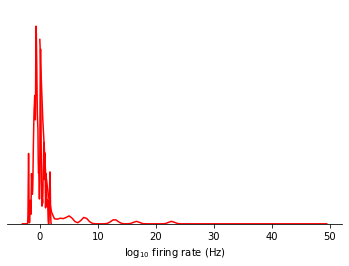

In [17]:

#Firing_rate plotting example
def plot_metric(data, bins, x_axis_label, color, max_value=-1):
    
    h, b = np.histogram(data, bins=bins, density=True)
    
    x = b[:-1]
    y = gaussian_filter1d(h, 1)
    plt.plot(x, y, color=color)
    plt.xlabel(x_axis_label)
    plt.gca().get_yaxis().set_visible(False)
    [plt.gca().spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
    if max_value < np.max(y) * 1.1:
        max_value = np.max(y) * 1.1
    plt.ylim([0, max_value])
    
    return max_value,h,b

Dataframe_KS_metrics = Metrics_per_sorter[0][0]

data_firingrate_KSresults = Dataframe_KS_metrics['firing_rate']
bins1 = np.linspace(0,50,100)
firing_rate_plot = plot_metric(data_firingrate_KSresults, bins1, 'Firing rate (Hz)', 'red')

#Since there are many units with low firing rates, let's use a log scale instead

data_firingrate_KSresults_log = np.log10(Dataframe_KS_metrics['firing_rate'])
bins2 = np.linspace(-3,2,100)
firing_rate_log, h, b = plot_metric(data_firingrate_KSresults_log, bins2, 'log$_{10}$ firing rate (Hz)', 'red')

# We can see that 90% of units that fire in the 7 Hz range after transformation of the log scale
            
def table_clusters_to_analyze(Dataframe_KS_metrics):
    Metrics = ["firing_rate", "presence_ratio", "isi_violation", "amplitude_cutoff", "nn_hit_rate"]
    Columns = ['Id_cluster'] + Metrics
    df = pd.DataFrame(columns = Columns)
    df['Id_cluster']= Dataframe_KS_metrics.index
    df.set_index('Id_cluster',drop=False,inplace=True)
    firing_rate_threshold = np.percentile(Dataframe_KS_metrics['firing_rate'],90)
    #All the clusters having a firing_rate less than 90% of the other clusters firing rate accross all the clusters will be highlighted
    presence_ratio_threshold = np.percentile(Dataframe_KS_metrics['presence_ratio'],50)
    #All the clusters having a presence_ratio less than the median presence ratio accross all the clusters will be highlighted
    isi_violation_threshold = 0.5
    #All the clusters having a  isi_violation higher than 0.5 will be highlighted for further analysis, 0.5 means that contamining spikes are occurring at roughly half the rate of "true" spikes for that unit. 
    amplitude_cutoff_threshold= 0.3
    #All the clusters having an amplitude cutoff higher than 0.3, meaning that 30% of the spikes are missing from the unit, it is the level of 'False negatives' and is completing the presence ratio analysis
    nn_hit_rate_threshold = 0.1
    #All the clusters having a nearest neighboor hit rate bigger than 10%, meaning that the fraction of their nearest neighbors that fall within the same cluster is higher than 10%
    Metrics=[["firing_rate",firing_rate_threshold],['presence_ratio',presence_ratio_threshold], ["isi_violation",isi_violation_threshold], ["amplitude_cutoff",amplitude_cutoff_threshold],  ["nn_hit_rate",nn_hit_rate_threshold]]
    #Thresholds = [firing_rate_threshold,presence_ratio_threshold,isi_violation_threshold,amplitude_cutoff_threshold,isolation_distance_threshold,nn_hit_rate_threshold]
    for i in Dataframe_KS_metrics.index:
        for m in Metrics :
            if m[0]=="presence_ratio":
                if Dataframe_KS_metrics.loc[i][m[0]]< m[1]:
                    c = Dataframe_KS_metrics.loc[i][m[0]] 
                    df.at[[i],[m[0]]]=c
            else:
                if Dataframe_KS_metrics.loc[i][m[0]] > m[1]:
                    c = Dataframe_KS_metrics.loc[i][m[0]] 
                    df.at[[i],[m[0]]]=c
    df.to_excel(os.path.join(Path_results,'clusters_to_analyze_manually.xlsx'), index = False)
    return df

df = table_clusters_to_analyze(Dataframe_KS_metrics)
#The following table gives the ID clusters that need to be analyzed further manually in Phy since they are crossing the thresholds settled concerning the quality metrics
print(df)


## Curation - Manual


We can now open the Phy view of the Kilosort2 results to start the manual aspect of the analysis based on the insights of the quality metrics.

The next step is then to go through this data and quickly verify that the sorting was efficient and coherent. 

In the Phy2 interface, we have access to all the data Kilosort2 was able to extract from the raw electrophysiological feed we provided it with, and we can manually check the treatment to fine tune the spike sorting.

To do so we integrate the insights obtained thanks to the table 'clusters to analyze' previously obtained by calculating the quality metrics.

The first step in this checking process is to look at the spike template window to see if the spikes were detected on the same channels and if they have similar shapes. If so, we can look at a principal component decomposition of the templates and compare them to see if they are similar along with the analysis of the similarity rate given by Phy2. Below can be seen the waveform view from Phy2, corresponding to the typical shape of a spike qualified as 'good'


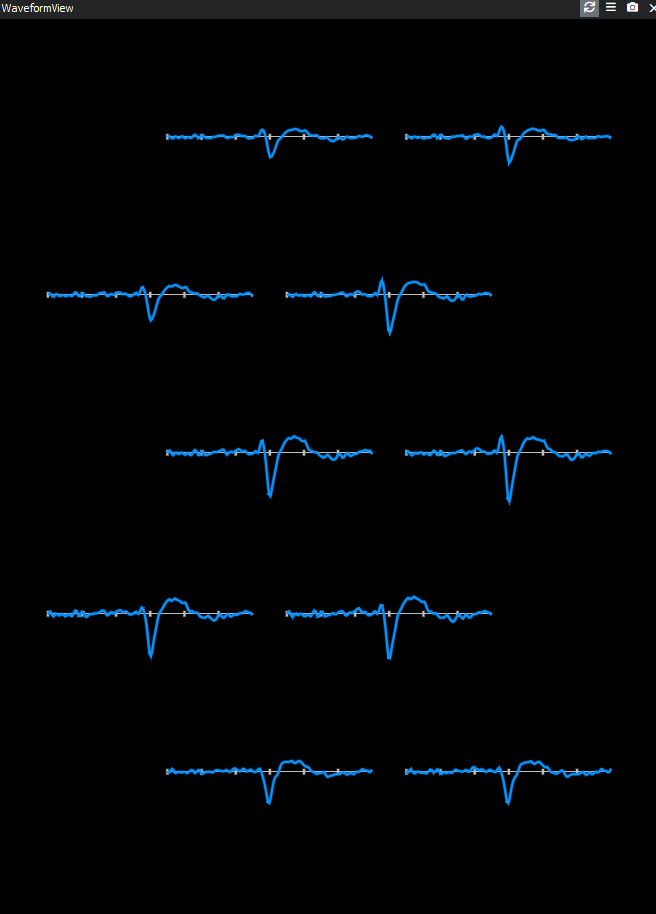


In the case where the components do match, we have a final look the crosscorrelogram to check on the refractory period. If the refractory period is not violated, we can merge the two clusters to create a single new one containing all of the spikes from the previous clusters. If at any point of this analysis we see a cluster that seems to have two distinct clusters in it (violation of the refractory period in the auto-correlogram and/or clear distinction of two groups in the principal component analysis), we can select the spikes we think belong to a separate group and split that cluster into two, one containing the selected spikes and the other containing the remaining spikes. After deciding to split or merge a cluster, we can label it based on our observation and criteriafor selection: “good” means we think the spikes have likely been emitted by a single neuron and that this cluster will be useful in our analysis; “multi-unit activity”, or “mua”, if we think the spikes have likely been produced by distinct neurons but are too noisy to be told apart, while still being useful for global statistics and computations; or “noise”, when we consider that the signal recorded is an artifact or does not contribute anything useful to our analysis of the data.

In [18]:


#Before the manual curation through Phy2 helped with the quality metrics table we have 79 units
print(len(sorting_KS2.get_unit_ids()))

#After curating the results we can reload it using the PhySortingExtractor, we exclude the cluster groups corresponding to noise
Phy_path = r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\Sorting_results\_KS2_results\Phy'
sorting_KS_phy_curated = se.PhySortingExtractor(Phy_path, exclude_cluster_groups=['noise'])

#After curation only 19 units are left
print(len(sorting_KS_phy_curated.get_unit_ids()))

79
19


## Curation - Consensus based


We can now do the last type of curation which is the agreement sorting based on our half-automatic curation of the Kilosort2 results and the results of Tridesclous along with Ironclust
We can use the comparison module. We first compare and match the output spike trains of the different sorters, and we can then extract a new SortingExtractor with only the units in agreement.
When extracting the units in agreement, the spike trains are modified so that only the true positive spikes between the comparison with the best match are used.


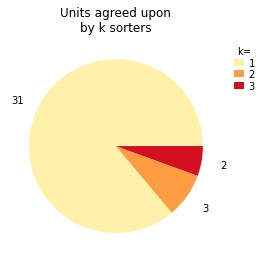

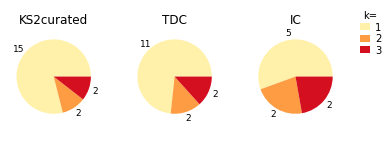

Impossible to delete temp file: C:\Temp\tmprxtn4683 Error [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Temp\\tmprxtn4683\\amplitudes.raw'


True

5


In [23]:

Sorters2=[sorting_KS_phy_curated,sorting_TDC,sorting_IC]
mcmp = sc.compare_multiple_sorters(Sorters2, ['KS2curated', 'TDC','IC'])
#The total number of units for which k sorters agree (unit agreement is defined as 50% spike match).
w = sw.plot_multicomp_agreement(mcmp)
plt.show()
#The number of units (per sorter) for which k sorters agree; most sorters find many units that other sorters do not.
w = sw.plot_multicomp_agreement_by_sorter(mcmp)
plt.show()

agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
isinstance(agreement_sorting, se.SortingExtractor)
print(len(agreement_sorting.get_unit_ids()))


In [ ]:
#Exporting the agreement sorting to Phy
Phy_agreement_folder = r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\Sorting_results\Phy-agr2'
st.postprocessing.export_to_phy(recording_loaded, 
                                agreement_sorting, output_folder=Phy_agreement_folder,verbose=True, recompute_info=True, max_channels_per_template=10)

The combination of automatic sorting by parametring Kilosort2,the quality metrics analysis and the manual curation lead us to find 19 good units. The agreement sorting let us confirm that 5 units were found by more than 2 sorters. These results will be further analyzed to fine tune the recorded traces of the units with the neurons they correspond and to realize population analysis.